In [1]:
pip install -q geopandas shap prophet xgboost lightgbm shapely contextily pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 22.2 MB/s eta 0:00:00


In [9]:
import re, requests, pandas as pd, io, gzip, pathlib, os, datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re



In [2]:
# Grab the latest NYC files
import re, requests, pandas as pd, io, gzip, pathlib, os, datetime as dt

CITY = "new-york-city"
BASE = "http://insideairbnb.com/get-the-data.html"
RAW_DIR = pathlib.Path("data/raw"); RAW_DIR.mkdir(parents=True, exist_ok=True)

page = requests.get(BASE).text
pattern = rf'https?://[^"]+{CITY}[^"]+\.csv\.gz'
links = re.findall(pattern, page)
latest_links = {
    pathlib.Path(url).stem.split('.')[0]: url
    for url in links
}

for name, url in latest_links.items():
    fn = RAW_DIR / f"{name}.csv.gz"
    if fn.exists():
        print(f"✓ {fn} already present")
        continue
    print(f"↓ downloading {url.split('/')[-1]}")
    r = requests.get(url, stream=True)
    with open(fn, 'wb') as f: f.write(r.content)

# Quick sanity peek
listings_head = pd.read_csv(RAW_DIR/'listings.csv.gz', nrows=5)
listings_head.head()


↓ downloading listings.csv.gz
↓ downloading calendar.csv.gz
↓ downloading reviews.csv.gz


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2539,https://www.airbnb.com/rooms/2539,20250501160219,2025-05-02,previous scrape,Superfast Wi-Fi. Clean & quiet home by the park,Renovated apartment home in an elevator buildi...,Close to Prospect Park and Historic Ditmas Park,https://a0.muscache.com/pictures/hosting/Hosti...,2787,...,5.0,4.75,4.88,NaN,f,5,1,4,0,0.08
1,2595,https://www.airbnb.com/rooms/2595,20250501160219,2025-05-02,city scrape,Skylit Midtown Manhattan Spacious Studio,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,https://a0.muscache.com/pictures/miso/Hosting-...,2845,...,4.8,4.81,4.40,NaN,f,3,3,0,0,0.26
2,5136,https://www.airbnb.com/rooms/5136,20250501160219,2025-05-02,city scrape,Spacious Family Friendly Duplex w/ Patio + Yard,"We welcome you to stay in our lovely 2 br, 130...",NaN,https://a0.muscache.com/pictures/miso/Hosting-...,7378,...,5.0,4.75,4.75,NaN,t,1,1,0,0,0.03
3,6848,https://www.airbnb.com/rooms/6848,20250501160219,2025-05-01,city scrape,Only 2 stops to Manhattan studio,Comfortable studio apartment with super comfor...,NaN,https://a0.muscache.com/pictures/e4f031a7-f146...,15991,...,4.8,4.69,4.58,NaN,f,1,1,0,0,1.00
4,6872,https://www.airbnb.com/rooms/6872,20250501160219,2025-05-01,city scrape,Uptown Sanctuary w/ Private Bath (Month to Month),This charming distancing-friendly month-to-mon...,This sweet Harlem sanctuary is a 10-20 minute ...,https://a0.muscache.com/pictures/miso/Hosting-...,16104,...,5.0,5.00,5.00,NaN,f,2,0,2,0,0.03


In [5]:
listings = pd.read_csv('listings.csv.gz')

In [6]:
def classify_column(dtype, n_unique, pct_missing, n_rows):
    """Heuristic label for each column."""
    if n_unique == n_rows:
        return "id-like"
    if n_unique <= 1:
        return "constant"

    if pd.api.types.is_bool_dtype(dtype):
        return "boolean"
    if pd.api.types.is_datetime64_any_dtype(dtype):
        return "datetime"
    if pd.api.types.is_numeric_dtype(dtype):
        # hand-wavy split between discrete and continuous
        return "numeric_discrete" if n_unique < 0.02 * n_rows else "numeric_continuous"
    # object, string, category, etc.
    return "categorical_low"  if n_unique < 20 else "categorical_high"

def column_summary(listings):
    """Return a DataFrame describing every column."""
    n_rows = len(listings)
    out = (
        pd.DataFrame({
            "dtype":       listings.dtypes,
            "n_unique":    listings.nunique(dropna=False),
            "pct_missing": listings.isna().mean().round(3) * 100,
        })
        .assign(
            category=lambda t: [
                classify_column(t.dtype[i], t.n_unique[i], t.pct_missing[i], n_rows)
                for i in range(len(t))
            ]
        )
        .sort_values("category")
    )
    return out

summary = column_summary(listings)
#summary.head(20)


<ipython-input-6-1385786544>:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  classify_column(t.dtype[i], t.n_unique[i], t.pct_missing[i], n_rows)


In [7]:
import os, sys, textwrap, math, json, itertools, collections, re

rows = []
for col in listings.columns:
    unique_vals = listings[col].dropna().unique()[:5]  # first 5 unique non‑null values
    rows.append({
        "column": col,
        "dtype": str(listings[col].dtype),
        "sample_values": ", ".join([str(v) for v in unique_vals])
    })

sample_df = pd.DataFrame(rows)


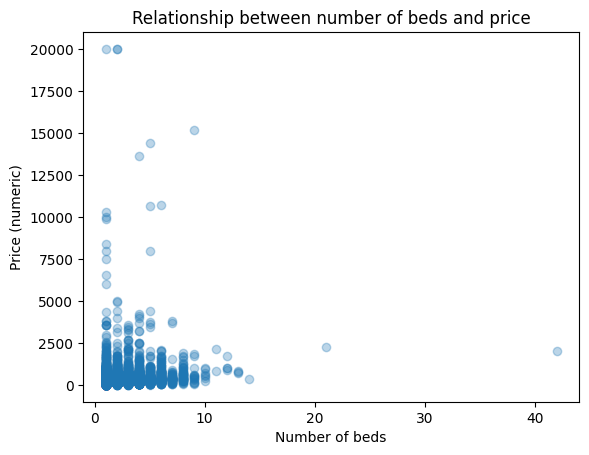

Pearson correlation (beds vs. price): 0.201


(None,
        beds  price_num
 0       1.0      200.0
 1       1.0       82.0
 2       5.0      765.0
 3       1.0      139.0
 4       1.0      130.0
 ...     ...        ...
 37427   1.0      221.0
 37428   1.0       87.0
 37429   1.0       72.0
 37431   3.0      299.0
 37432   2.0      200.0
 
 [21594 rows x 2 columns],
     beds  median_price
 0    1.0         109.0
 1    2.0         170.0
 2    3.0         210.0
 3    4.0         259.0
 4    5.0         275.0
 5    6.0         366.5
 6    7.0         362.0
 7    8.0         544.0
 8    9.0         470.0
 9   10.0         576.0
 10  11.0        1467.0
 11  12.0        1019.5
 12  13.0         750.0
 13  14.0         359.0
 14  21.0        2272.0
 15  42.0        2029.0)

In [10]:
def to_price(val):
    if pd.isna(val):
        return np.nan
    if isinstance(val, str):
        # strip currency symbols and thousands separators
        val = re.sub(r'[^\d.]', '', val)
    try:
        return float(val)
    except ValueError:
        return np.nan

df_clean = listings.copy()
df_clean['price_num'] = df_clean['price'].apply(to_price)

df_plot = (
    df_clean[['beds', 'price_num']]
    .dropna()
    .loc[lambda d: (d['beds'] > 0) & (d['price_num'] > 0)]
)

plt.figure()
plt.scatter(df_plot['beds'], df_plot['price_num'], alpha=0.3)
plt.xlabel("Number of beds")
plt.ylabel("Price (numeric)")
plt.title("Relationship between number of beds and price")
plt.show()

median_df = (
    df_plot.groupby('beds')['price_num']
    .median()
    .reset_index()
    .rename(columns={'price_num': 'median_price'})
    .sort_values('beds')
)

pearson = df_plot['beds'].corr(df_plot['price_num'])
print(f"Pearson correlation (beds vs. price): {pearson:.3f}"), df_plot, median_df


In [11]:
# keep positive priced rows only
df_clean = df_clean.loc[(df_clean['price_num'] > 0) & df_clean['neighbourhood_cleansed'].notna()
                  & df_clean['neighbourhood_group_cleansed'].notna()]

# Median nightly price by neighbourhood_cleansed

agg = (
    df_clean
    .groupby(['neighbourhood_group_cleansed', 'neighbourhood_cleansed'])
    .agg(
        median_price=('price_num', 'median'),
        mean_price=('price_num', 'mean'),
        listings=('price_num', 'size')
    )
    .reset_index()
    .sort_values('median_price')
)
agg['mean_price'] = agg['mean_price'].round(2)
agg

,neighbourhood_group_cleansed,neighbourhood_cleansed,median_price,mean_price,listings
18,Bronx,Hunts Point,53.0,67.44,16
192,Staten Island,Grant City,53.0,85.67,9
8,Bronx,Co-op City,55.5,57.00,6
55,Brooklyn,Borough Park,56.0,81.00,28
109,Manhattan,Inwood,57.0,97.81,88
...,...,...,...,...,...
94,Brooklyn,Vinegar Hill,362.0,351.78,18
97,Manhattan,Battery Park City,362.5,753.67,36
123,Manhattan,Tribeca,391.5,586.76,108
117,Manhattan,NoHo,529.0,565.83,18


In [12]:
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim

geocoder = Nominatim(user_agent="bnb-prices")
rate     = RateLimiter(geocoder.geocode, min_delay_seconds=1)

def get_lat_lon(place):
    try:
        loc = rate(place + ", New York, USA")
        return loc.latitude, loc.longitude
    except:
        return np.nan, np.nan

agg[['Latitude', 'Longitude']] = (
    agg['neighbourhood_cleansed']
      .apply(lambda x: pd.Series(get_lat_lon(x)))
)

In [14]:
# 1. Setup
# geodatasets gives us the sample shapefiles that used to live in geopandas.datasets
!pip install --quiet geopandas geodatasets geopy shapely pyproj rtree

import pandas as pd, geopandas as gpd
from geodatasets import get_path
from shapely.geometry import Point
from geopy.distance import geodesic

df = agg
df = df.dropna(subset=['Latitude', 'Longitude', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed'])

# 2. Pull the NYC borough polygons
nybb_path = get_path("nybb")          # → local path to the shapefile
nybb      = gpd.read_file(nybb_path).to_crs(epsg=4326)

# 3. Authoritative fixes (same dict as before)
fixes = {
    ('longwood',           'bronx'): (40.8173,  -73.8993),
    ('belmont',            'bronx'): (40.8550,  -73.8860),
    ('schuylerville',      'bronx'): (40.8350,  -73.8330),
    ('concourse',          'bronx'): (40.8270,  -73.9230),
    ('norwood',            'bronx'): (40.8780,  -73.8780),
    ('mount hope',         'bronx'): (40.8503,  -73.9092),
    ('claremont village',  'bronx'): (40.8408,  -73.9075),
    ('eastchester',        'bronx'): (40.8820,  -73.8300),
    ('clifton',            'staten island'): (40.6214, -74.0714),
    ('lighthouse hill',    'staten island'): (40.5735, -74.1343),
    ("bull's head",        'staten island'): (40.6043, -74.1575),
    ('concord',            'staten island'): (40.6082, -74.0843),
    ('silver lake',        'staten island'): (40.6212, -74.0920),
    ('shore acres',        'staten island'): (40.6058, -74.0667),
    ('randall manor',      'staten island'): (40.6380, -74.1020),
    ('red hook',           'brooklyn'): (40.6770, -74.0110),
    ('vinegar hill',       'brooklyn'): (40.7020, -73.9810),
    ('kensington',         'brooklyn'): (40.6385, -73.9732),
    ('inwood',             'manhattan'): (40.8670, -73.9220),
    ('highbridge',         'bronx'):          (40.8370, -73.9290),   # :contentReference[oaicite:0]{index=0}
    ('pelham gardens',     'bronx'):          (40.8610, -73.8450),   # :contentReference[oaicite:1]{index=1}
    ('west brighton',      'staten island'):  (40.6350, -74.1120),   # :contentReference[oaicite:2]{index=2}
    ('throgs neck',        'bronx'):          (40.8230, -73.8200),   # :contentReference[oaicite:3]{index=3}
    ('bay terrace',        'queens'):         (40.7830, -73.7810),   # :contentReference[oaicite:4]{index=4}
    ('bellerose',          'queens'):   (40.7244, -73.7154),   # :contentReference[oaicite:0]{index=0}
    ('jamaica hills',      'queens'):   (40.7128, -73.7992),   # :contentReference[oaicite:1]{index=1}
    ('navy yard',          'brooklyn'): (40.7019, -73.9689)    # :contentReference[oaicite:2]{index=2}

}

# apply the fixes
df['ngh_key']  = df['neighbourhood_cleansed'].str.lower().str.strip()
df['boro_key'] = df['neighbourhood_group_cleansed'].str.lower().str.strip()

for (n, b), (lat, lon) in fixes.items():
    m = (df['ngh_key'] == n) & (df['boro_key'] == b)
    df.loc[m, ['Latitude', 'Longitude']] = [lat, lon]

# 4. GIS sanity-check (unchanged)
pts  = gpd.GeoDataFrame(df,
                        geometry=gpd.points_from_xy(df.Longitude, df.Latitude),
                        crs='EPSG:4326')
joined = gpd.sjoin(pts, nybb[['BoroName', 'geometry']],
                   predicate='within', how='left')

bad_boro = joined[joined['neighbourhood_group_cleansed'] != joined['BoroName']]
print(f'{len(bad_boro)} rows have coordinates falling outside their stated borough')
print(bad_boro[['neighbourhood_cleansed','neighbourhood_group_cleansed',
                'Latitude','Longitude','BoroName']].head())

# 6. Save clean file
df.drop(columns=['ngh_key','boro_key']).to_csv(
    'agg_cleaned.csv', index=False)
print('Wrote agg_cleaned.csv')


Extracting 'nybb_16a/nybb.shp' from '/root/.cache/geodatasets/nybb_16a.zip' to '/root/.cache/geodatasets/nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.shx' from '/root/.cache/geodatasets/nybb_16a.zip' to '/root/.cache/geodatasets/nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.dbf' from '/root/.cache/geodatasets/nybb_16a.zip' to '/root/.cache/geodatasets/nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.prj' from '/root/.cache/geodatasets/nybb_16a.zip' to '/root/.cache/geodatasets/nybb_16a.zip.unzip'


1 rows have coordinates falling outside their stated borough
    neighbourhood_cleansed neighbourhood_group_cleansed  Latitude  Longitude  \
135              Bellerose                       Queens   40.7244   -73.7154   

    BoroName  
135      NaN  
Wrote agg_cleaned.csv


<ipython-input-14-844548931>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ngh_key']  = df['neighbourhood_cleansed'].str.lower().str.strip()
<ipython-input-14-844548931>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['boro_key'] = df['neighbourhood_group_cleansed'].str.lower().str.strip()
